In [44]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [2]:
# загрузка данных
data = pd.read_csv('C:\projects\Python\mlcourse_open\Lesson4\data/microchip_tests.txt',
                   header=None, names = ('test1','test2','released'))
# информация о наборе данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
test1       118 non-null float64
test2       118 non-null float64
released    118 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.8 KB


In [4]:
data.head()

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [5]:
X = data.ix[:,:2].values
y = data.ix[:,2].values

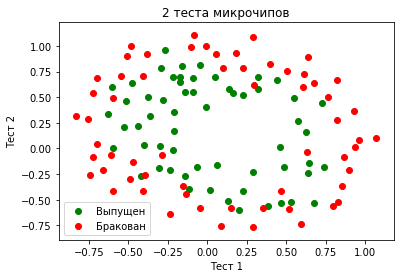

In [15]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов')
plt.legend();

In [16]:
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))


    # каждой точке в сетке [x_min, m_max]x[y_min, y_max]
    # ставим в соответствие свой цвет
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

### Добавляем полиноминальные признаки для результатов тестирования!

Полиномиальными признаками до степени $d$ для двух переменных $x_1$ и $x_2$ мы называем следующие:
$$\large \{x_1^d, x_1^{d-1}x_2, \ldots x_2^d\} = \{x_1^ix_2^j\}_{i+j=d, i,j \in \mathbb{N}}$$

Например, для $d=3$ это будут следующие признаки:
$$\large 1, x_1, x_2, x_1^2, x_1x_2, x_2^2, x_1^3, x_1^2x_2, x_1x_2^2, x_2^3$$

Нарисовав треугольник Пифагора, Вы сообразите, сколько таких признаков будет для $d=4,5...$ и вообще для любого $d$. Попросту говоря, таких признаков экспоненциально много, и строить, скажем, для 100 признаков полиномиальные степени 10 может оказаться затратно (а более того, и не нужно).

Создадим объект sklearn, который добавит в матрицу $X$ полиномиальные признаки вплоть до степени 7.


In [17]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)



In [18]:
X_poly.shape

(118, 36)

In [19]:
X_poly

array([[  1.00000000e+00,   5.12670000e-02,   6.99560000e-01, ...,
          4.40352691e-04,   6.00879959e-03,   8.19926237e-02],
       [  1.00000000e+00,  -9.27420000e-02,   6.84940000e-01, ...,
          1.29662850e-03,  -9.57616530e-03,   7.07241450e-02],
       [  1.00000000e+00,  -2.13710000e-01,   6.92250000e-01, ...,
          7.26046625e-03,  -2.35181216e-02,   7.61799619e-02],
       ..., 
       [  1.00000000e+00,  -4.84450000e-01,   9.99270000e-01, ...,
          2.33836427e-01,  -4.82331978e-01,   9.94901177e-01],
       [  1.00000000e+00,  -6.33640000e-03,   9.99270000e-01, ...,
          4.00036314e-05,  -6.30869717e-03,   9.94901177e-01],
       [  1.00000000e+00,   6.32650000e-01,  -3.06120000e-02, ...,
         -1.07593379e-08,   5.20611480e-10,  -2.51907984e-11]])

Доля правильных ответов классификатора на обучающей выборке: 0.627


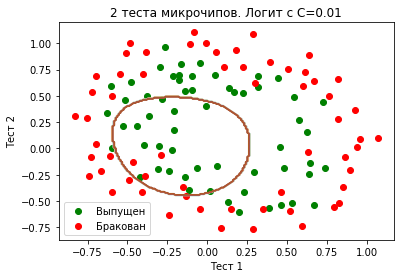

In [26]:
C = 1e-2
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=0.01')
plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", 
      round(logit.score(X_poly, y), 3))

Увеличим $C$ до 1. Тем самым мы ослабляем регуляризацию, теперь в решении значния весов логистической регрессии могут оказаться больше (по модулю), чем в прошлом случае.

Доля правильных ответов классификатора на обучающей выборке: 0.831


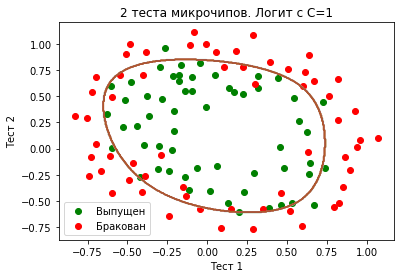

In [27]:
C = 1
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=1')
plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", 
      round(logit.score(X_poly, y), 3))

Еще увеличим $C$ – до 10 тысяч. Теперь регуляризации явно недостаточно, и мы наблюдаем переобучение. Можно заметить, что в прошлом случае (при $C$=1 и "гладкой" границе) доля правильных ответов модели на обучающей выборке не намного ниже, чем в 3 случае, зато на новой выборке, можно себе представить, 2 модель сработает намного лучше.

Доля правильных ответов классификатора на обучающей выборке: 0.873


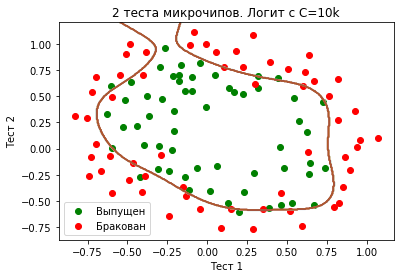

In [29]:
C = 1e4
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=10k')
plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", 
      round(logit.score(X_poly, y), 3))

Вообщем чем боьше регуляризация, тем меньше она штрафует веса и выевляяется супер признак - возможно переобучение, Чем регуляризация сильнее(меньше) Тем модель ожет не доучится из за высоких штраов по ошибке.

### Нужно вычеслять регуляризацию на кросс валидации.



In [30]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(X_poly, y)

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished


LogisticRegressionCV(Cs=array([  1.00000e-02,   1.02334e-02, ...,   9.77192e+02,   1.00000e+03]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=1)

In [41]:
logit_searcher.C_

array([ 198.8827857])

In [46]:
y_pred_3 = logit_searcher.predict_proba(X_poly)[:, 1]
# считаем качество
score = roc_auc_score(y, y_pred_3)
score

0.93764367816091942

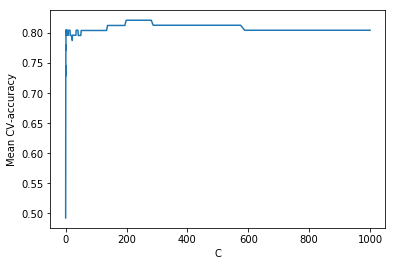

In [32]:


plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');



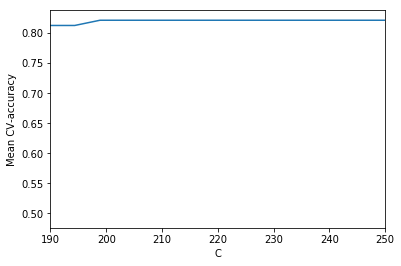

In [36]:


plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');
plt.xlim((190,250));

